# Лабораторная работа №6
Ниже приведена и подробно описана базовая реализация варианта метода обобщенного градиента, основанного на вычислении статистических моментов первых трех порядков: среднего значения, стандартного отклонения и асимметрии. Базовая раелизация в явном виде использует проход по пикселам изображения, из-за чего на больших изображениях работает медленно.

In [10]:
# [Block 1]
import numpy as np
import scipy.stats as stats
import scipy.signal as signal
import skimage.morphology as skim
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
from skimage import io

Функция getGGwindow(r) генерирует окно заданного радиуса для вычисления величины обобщенного градиента вдоль оси Х. Впоследствии величина градиента в выбранном направлении будет определяться как разница некоторой величины, вычисленной в двух половинах окна. В этой работе все вычисления рекомендуется производить с использованием окна радиуса 20.



2D Generalized Gradient (GG) windows of radius 7 and 20
Window halves are filled with "1" and "2"


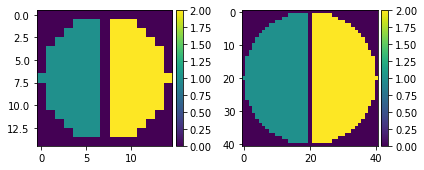

In [21]:
# [Block 2]
def getGGwindow(r):
    wnd1 = skim.disk(r).astype(int) * 2
    wnd1[:, 0:r + 1] = 0
    wnd2 = skim.disk(r).astype(int) * 1
    wnd2[:, r:] = 0
    return wnd1 + wnd2

rs = [7, 20]
print('\n\n2D Generalized Gradient (GG) windows of radius {} and {}'.format(rs[0], rs[1]))
print('Window halves are filled with "1" and "2"')
io.imshow_collection([getGGwindow(rs[0]), getGGwindow(rs[1])], cmap=cm.viridis)
io.show()

# Исходные данные

В работе рассматриваются два тестовых двумерных изображения. 
* test_image_1 (256х256) -- участок слоя трехмерного КТ-изображения фантома, использованного в [1]. На изображении присутствует неявная граница между желатином и водой с растворенным контрастирующим веществом.
* test_image_2 (512х512) --  синтетическое изображение с невидимым объектом (прямоугольником). Распределения яркостей пикселов фона и объекта здесь имеют одинаковые средние значения и стандартное отклонение, но разную асимметрию (фон - 0.0, объект - 0.50)

[1] http://elib.bsu.by/bitstream/123456789/158762/1/Kovalev_Snezhko_Kharuzhyk_Liauchuk.pdf



Test images:
(1) Slice of CT scan of a jelly phantom with unclear border (256 x 256)
(2) Synthetic image with hidden rectangle inside (512 x 512)


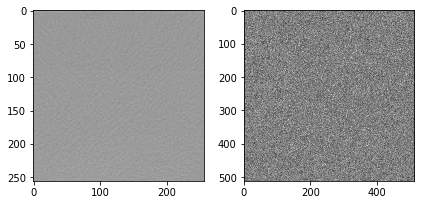

In [4]:
# [Block 3]
fn1 = 'test_image_1.png'
fn2 = 'test_image_2.png'
im1 = io.imread(fn1)
im2 = io.imread(fn2)

print('\nTest images:')
print('(1) Slice of CT scan of a jelly phantom with unclear border ({} x {})'.format(im1.shape[0], im1.shape[1]))
print('(2) Synthetic image with hidden rectangle inside ({} x {})'.format(im2.shape[0], im2.shape[1]))
io.imshow_collection([im1, im2])
io.show()


# Базовая реализация метода
Ниже приведена функция, вычисляющая карту величины обобщенного градиента. На вход функции подается изображение "im", радиус окна "r" и хэндл функции "featureFunction", вычисляющей нужную нам характеристику. Окно для вычисления градиента вдоль оси Y получается из окна для оси Х путем транспонирования. Для каждогопиксела изображения (кроме граничных) выделяются наборы пикслоев, соответствующие разным половинам окна, вычисляются нужные характеристики и на их основе строится результирующая карта градиента "ggmap".

Ниже приведены примеры применения функции.
1. Вычисление градиента среднего значения (featureFunction=np.mean) для test_image_1, время выполнения: 2.4 сек
2. Вычисление градиента стандартного отклонения (featureFunction=np.std) для test_image_2, время выполнения: 23.0 сек
3. Вычисление градиента асимметрии (featureFunction=stats.skew) для test_image_2, время выполнения: 139.9 сек

Как видно из результатов, границу воды и желатина удалось выявить при помощи градиента среднего значения. Выявить прямоугольник на test_image_2 удалось только при помощи градиента асимметрии.


Calculating gradient of Mean for "test_image_1.png" (r = 20)
Elapsed time: 2.4 sec


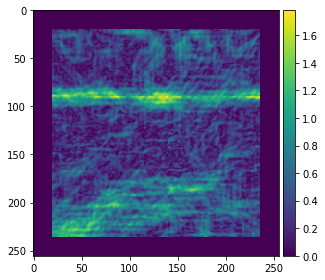


Calculating gradient of STD for "test_image_2.png" (r = 20)
Elapsed time: 23.0 sec


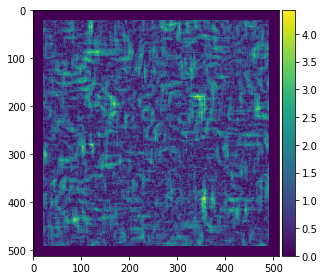


Calculating gradient of Skewness "test_image_2.png" (r = 20)
Elapsed time: 139.9 sec


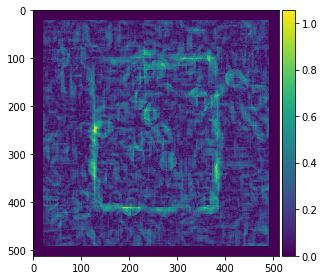

In [22]:
# [Block 4]
def buildGGmap2D(im, r, featureFunction):
    wndx = getGGwindow(r)
    wndy = np.transpose(wndx).copy()

    ggmap = np.zeros(im.shape, dtype=float)
    for y in range(r, im.shape[0] - r):
        for x in range(r, im.shape[1] - r):
            sub = im[y - r:y + r + 1, x - r:x + r + 1]

            x1 = sub[wndx == 1].flatten().astype(float)
            x2 = sub[wndx == 2].flatten().astype(float)
            diffX = featureFunction(x1) - featureFunction(x2)

            y1 = sub[wndy == 1].flatten().astype(float)
            y2 = sub[wndy == 2].flatten().astype(float)
            diffY = featureFunction(y1) - featureFunction(y2)

            ggmap[y, x] = diffX**2 + diffY**2

    ggmap = np.power(ggmap, 0.5)
    return ggmap

r = 20

print('\nCalculating gradient of Mean for "{}" (r = {})'.format(fn1, r))
start = time.time()
map1 = buildGGmap2D(im1, r, np.mean)
print('Elapsed time: {0:.1f} sec'.format(time.time() - start))
io.imshow(map1, cmap=cm.viridis)
io.show()

print('\nCalculating gradient of STD for "{}" (r = {})'.format(fn2, r))
start = time.time()
map2 = buildGGmap2D(im2, r, np.std)
print('Elapsed time: {0:.1f} sec'.format(time.time() - start))
io.imshow(map2, cmap=cm.viridis)
io.show()

print('\nCalculating gradient of Skewness "{}" (r = {})'.format(fn2, r))
start = time.time()
map3 = buildGGmap2D(im2, r, stats.skew)
print('Elapsed time: {0:.1f} sec'.format(time.time() - start))
io.imshow(map3, cmap=cm.viridis)
io.show()


# Задание

В базовой реализации метода осуществляется проход по всем пикселам изображения, кроме граничных. Из-за этого реализация работает крайне медленно в случае больших изображений. В случае трехмерных изображений с использованием трехмерных скользящих окон ситуация становится вовсе критичной.

В данной работе нужно реализовать методы вычисления градиента среднего значения, стандартного отклонения и асимметрии с использованим быстрых встроенных функций (например свертки scipy.signal.convolve2d) вместо прямого прохода по пикселам исходного изображения. "Быструю" реализацию методов нужно протестировать на тех же изображениях и сравнить с результатами работы базовой реализации: 
* результирующие карты градиента должны совпадать
* время выполнения должно сократиться (для градиента асимметрии test_image_2 - значительно)

Очевидно, на разных машинах время выполнения может сильно различаться. На компьютере с **i7-6700 CPU @ 3.40GHz** время вычисления градиента асимметрии для test_image_2 составило около 15 секунд (в 9 раз быстрее базовой реализации).

Перед сравнением результатов рекомендуется занулить значения граничных пикселов (функция borderToZeros(map, r)), иначе можно за деревьями леса не увидеть.

Стандартное отклонение np.std вычисляется по формуле: std = sqrt(mean(abs(x - x.mean())**2)), та же формула на Википедии (см. Definition of population values): https://en.wikipedia.org/wiki/Standard_deviation

Формула для вычисления коэффициента асимметрии scipy.stats.skew - там же (см. Definition): https://en.wikipedia.org/wiki/Skewness

Обратите особое внимание на формульные преобразования в статьях на Вики - могут очень пригодиться.

In [84]:
# [Block 5]
def borderToZeros(map, r):
    map[0:r, :] = 0
    map[range(map.shape[0] - r, map.shape[0]), :] = 0
    map[:, 0:r] = 0
    map[:, range(map.shape[1] - r, map.shape[1])] = 0
    return map

# Continue here ...

r = 20

# Helper lambdas and methods.
split = lambda win, val, sz: (win==val).astype(float)/sz

def neg(win):
    win_neg = win.copy()
    win_neg[win==2] = -1
    return win_neg

def gradientMean(image):
    win = getGGwindow(r).astype(float)
    sz = np.count_nonzero(win) // 2
    
    horiz = signal.convolve2d(image, neg(win)/sz)
    vert = signal.convolve2d(image, neg(win).T/sz)
    return borderToZeros((horiz ** 2 + vert ** 2) ** 0.5, 2 * r)
    
def gradientStandartDeviation(image):
    win = getGGwindow(r).astype(float)
    sz = np.count_nonzero(win) // 2
    
    squared = image ** 2
    
    horiz_left = signal.convolve2d(squared, split(win,1,sz)) - signal.convolve2d(image, split(win,1,sz)) ** 2
    horiz_right = signal.convolve2d(squared, split(win,2,sz)) - signal.convolve2d(image, split(win,2,sz)) ** 2
    vert_up = signal.convolve2d(squared, split(win,1,sz).T) - signal.convolve2d(image, split(win,1,sz).T) ** 2
    vert_btm = signal.convolve2d(squared, split(win,2,sz).T) - signal.convolve2d(image, split(win,2,sz).T) ** 2
    
    horiz = horiz_right ** 0.5 - horiz_left ** 0.5
    vert = vert_btm ** 0.5 - vert_up ** 0.5
    
    return borderToZeros((horiz ** 2 + vert ** 2) ** 0.5, 2 * r)

def gradientSkewness(image):
    win = getGGwindow(r).astype(float)
    sz = np.count_nonzero(win) // 2
    
    squared = image ** 2
    cubed = image ** 3
    
    disp_left = signal.convolve2d(squared, split(win,1,sz)) - signal.convolve2d(image, split(win,1,sz)) ** 2
    disp_right = signal.convolve2d(squared, split(win,2,sz)) - signal.convolve2d(image, split(win,2,sz)) ** 2
    expect_left = signal.convolve2d(cubed, split(win,1,sz)) - 3 * signal.convolve2d(image, split(win,1,sz)) * disp_left - signal.convolve2d(image, split(win,1,sz)) ** 3
    expect_right = signal.convolve2d(cubed, split(win,2,sz)) - 3 * signal.convolve2d(image, split(win,2,sz)) * disp_right - signal.convolve2d(image, split(win,2,sz)) ** 3
    div_on_left = disp_left ** 1.5
    div_on_right = disp_right ** 1.5
    horiz = expect_left / div_on_left - expect_right / div_on_right
    
    # same for vertical.
    disp_top = signal.convolve2d(squared, split(win,1,sz).T) - signal.convolve2d(image, split(win,1,sz).T) ** 2
    disp_btm = signal.convolve2d(squared, split(win,2,sz).T) - signal.convolve2d(image, split(win,2,sz).T) ** 2
    expect_top = signal.convolve2d(cubed, split(win,1,sz).T) - 3 * signal.convolve2d(image, split(win,1,sz).T) * disp_top - signal.convolve2d(image, split(win,1,sz).T) ** 3
    expect_btm = signal.convolve2d(cubed, split(win,2,sz).T) - 3 * signal.convolve2d(image, split(win,2,sz).T) * disp_btm - signal.convolve2d(image, split(win,2,sz).T) ** 3
    div_on_top = disp_top ** 1.5
    div_on_btm = disp_btm ** 1.5
    vert = expect_top / div_on_top - expect_btm / div_on_btm
    
    
    return borderToZeros((horiz ** 2 + vert ** 2) ** 0.5, 2 * r)

Image: test_image_1.png    Test:  Mean
Time: 0.793522834777832


/usr/local/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


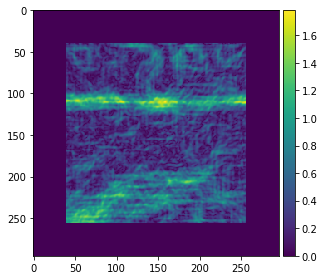

Image: test_image_2.png    Test:  STD
Time: 11.637020826339722


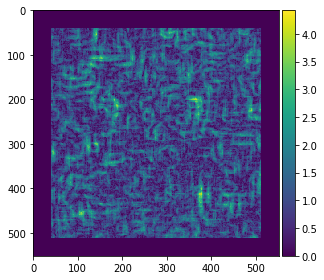

Image: test_image_2.png    Test:  Skewness


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


Time: 29.74601912498474


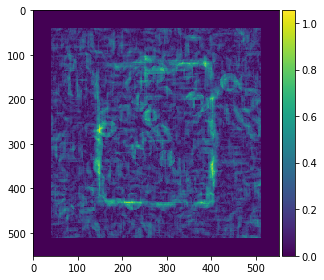

In [86]:
# Ensuring images.
im1 = im1.astype(float)
im2 = im2.astype(float)

def runTest(filename, image, testname, func):
    print("Image:", filename, "   Test: ", testname)
    start_time = time.time()
    grad = func(image)
    print("Time:", time.time() - start_time)
    io.imshow(grad, cmap=cm.viridis)
    io.show()

# The first image.
runTest(fn1, im1, "Mean", gradientMean)

# The second image.
runTest(fn2, im2, "STD", gradientStandartDeviation)
runTest(fn2, im2, "Skewness", gradientSkewness)